<a href="https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/main/notebooks/02-Basic_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages and Setup Variables


In [33]:
# !pip install -q openai==1.107.0 google-genai==1.36.0

In [34]:
import os

# Set the "OPENAI_API_KEY" and "GOOGLE_API_KEY" in the Python environment. Will be used by OpenAI client later.

# os.environ["OPENAI_API_KEY"] = "<YOUR_OPENAI_API_KEY>"
# os.environ["GOOGLE_API_KEY"] =  "<YOUR_GOOGLE_API_KEY>"

# from google.colab import userdata

# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["GOOGLE_API_KEY"] =  userdata.get('Google_api_key')

In [35]:
# False: Generate the embedding for the dataset. (Associated cost with using OpenAI endpoint)
# True: Load the dataset that already has the embedding vectors.
load_embedding = False

# Load Dataset


## Download Dataset (JSON)


The dataset includes several articles from the TowardsAI blog, which provide an in-depth explanation of the LLaMA2 model.


In [36]:
# !wget https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/mini-llama-articles.csv

In [37]:
# !wget https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/mini-llama-articles-with_embeddings.csv

## Read File


In [38]:
# Split the input text into chunks of specified size.
def split_into_chunks(text, chunk_size=1024):
    chunks = []
    for i in range(0, len(text), chunk_size):
        chunks.append(text[i : i + chunk_size])

    return chunks

In [39]:
import csv

chunks = []

# Load the file as a CSV
with open("./mini-llama-articles.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)

    for idx, row in enumerate(csv_reader):
        if idx == 0:
            continue
            # Skip header row
        chunks.extend(split_into_chunks(row[1])) # row[1] contains the article text divided into chunks so extend() is used, not append()

In [40]:
with open("./mini-llama-articles.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)
    test = [row for idx, row in enumerate(csv_reader) if idx < 2]

In [41]:
test

[['title', 'content', 'url', 'source'],
 ["Beyond GPT-4: What's New?",
  'LLM Variants and Meta\'s Open Source Before shedding light on four major trends, I\'d share the latest Meta\'s Llama 2 and Code Llama. Meta\'s Llama 2 represents a sophisticated evolution in LLMs. This suite spans models pretrained and fine-tuned across a parameter spectrum of 7 billion to 70 billion. A specialized derivative, Llama 2-Chat, has been engineered explicitly for dialogue-centric applications. Benchmarking revealed Llama 2\'s superior performance over most extant open-source chat models. Human-centric evaluations, focusing on safety and utility metrics, positioned Llama 2-Chat as a potential contender against proprietary, closed-source counterparts. The development trajectory of Llama 2 emphasized rigorous fine-tuning methodologies. Meta\'s transparent delineation of these processes aims to catalyze community-driven advancements in LLMs, underscoring a commitment to collaborative and responsible AI de

In [42]:
print("number of articles:", idx)
print("number of chunks:", len(chunks))

number of articles: 14
number of chunks: 174


In [43]:
import pandas as pd

# Convert the JSON list to a Pandas Dataframe
df = pd.DataFrame(chunks, columns=["chunk"])

df.keys()

Index(['chunk'], dtype='object')

# Generate Embedding


In [44]:
from openai import OpenAI

client = OpenAI()


# Defining a function that converts a text to embedding vector using OpenAI's Ada model.
def get_embedding(text):
    try:
        # Remove newlines
        text = text.replace("\n", " ")
        res = client.embeddings.create(input=[text], model="text-embedding-3-small")

        return res.data[0].embedding

    except:
        return None

In [45]:
load_embedding

False

In [46]:
load_embedding = False

In [47]:
import ast
from tqdm.notebook import tqdm
import numpy as np

def to_array_safe(x):
    try:
        return np.array(ast.literal_eval(x), dtype=float)
    except Exception:
        return np.nan  # or np.zeros(dim)

# Generate embedding
if not load_embedding:
    print("Generating embeddings...")
    embeddings = []
    for index, row in tqdm(df.iterrows()):
        # df.at[index, 'embedding'] = get_embedding( row['chunk'] )
        embeddings.append(get_embedding(row["chunk"]))

    embeddings_values = pd.Series(embeddings)
    df.insert(loc=1, column="embedding", value=embeddings_values)

# Or, load the embedding from the file.
else:
    print("Loaded the embedding file.")
    # Load the file as a CSV
    df = pd.read_csv("mini-llama-articles-with_embeddings.csv")

    # Safely convert embedding column to an array, handling potential errors
    df["embedding"] = df["embedding"].apply(to_array_safe)

    # Convert embedding column to an array (EVAL() is unsafe, so use with caution)
    # df["embedding"] = df["embedding"].apply(lambda x: np.array(eval(x)), 0)

Generating embeddings...


0it [00:00, ?it/s]

In [48]:
df.to_csv('mini-llama-articles-with_embeddings.csv')

# User Question


In [49]:
# Define the user question, and convert it to embedding.
QUESTION = "How many parameters LLaMA2 model has?"
QUESTION_emb = get_embedding(QUESTION)

len(QUESTION_emb)

1536

# Test Cosine Similarity


Calculating the similarity of embedding representations can help us to find pieces of text that are close to each other. In the following sample you see how the Cosine Similarity metric can identify which sentence could be a possible answer for the given user question. Obviously, the unrelated answer will score lower.


In [50]:
BAD_SOURCE_emb = get_embedding("The sky is blue.")
GOOD_SOURCE_emb = get_embedding("LLaMA2 model has a total of 2B parameters.")

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

# A sample that how a good piece of text can achieve high similarity score compared
# to a completely unrelated text.
print("> Bad Response Score:", cosine_similarity([QUESTION_emb], [BAD_SOURCE_emb]))
print("> Good Response Score:", cosine_similarity([QUESTION_emb], [GOOD_SOURCE_emb]))

> Bad Response Score: [[0.02578727]]
> Good Response Score: [[0.83154609]]


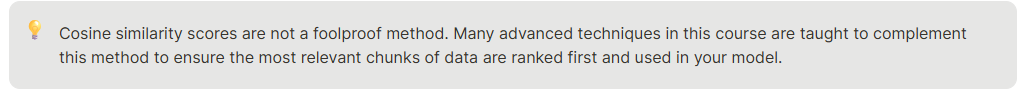

# Calculate Cosine Similarities


In [52]:
# The similarity between the questions and each part of the essay.
cosine_similarities = cosine_similarity([QUESTION_emb], df["embedding"].tolist())

print(cosine_similarities)

[[0.46767499 0.46912464 0.25989879 0.29374288 0.319654   0.40160312
  0.41500898 0.45266289 0.45935869 0.12609425 0.11750504 0.01348838
  0.22602134 0.21423916 0.10145219 0.33064027 0.10735807 0.346859
  0.16311856 0.08727145 0.3481163  0.22834732 0.19201346 0.26471736
  0.24928956 0.34831767 0.24828999 0.3276031  0.41445729 0.41337977
  0.46363194 0.38341214 0.46888341 0.35636739 0.35398223 0.3027117
  0.29934588 0.29252605 0.40035147 0.46468364 0.39473083 0.41042047
  0.44715544 0.43173664 0.35909244 0.33973082 0.51356637 0.20932135
  0.40203991 0.32829097 0.42834358 0.48270619 0.45036044 0.34256287
  0.32083244 0.42588004 0.24622426 0.18094855 0.23648678 0.34274622
  0.3437286  0.20476358 0.1975709  0.22448873 0.21110849 0.42297719
  0.26382997 0.30438172 0.33612975 0.38368357 0.23536253 0.24351588
  0.37086862 0.28025883 0.49052816 0.53044722 0.37817696 0.43770825
  0.37755067 0.39255233 0.30081934 0.41710617 0.4674553  0.45420047
  0.35169137 0.21222866 0.4262131  0.31600177 0.440

In [55]:
import numpy as np

number_of_chunks_to_retrieve = 3

# Sort the scores
highest_index = np.argmax(cosine_similarities)
print("Highest score index:", highest_index)

# Pick the N highest scored chunks
indices = np.argsort(cosine_similarities[0])[::-1][:number_of_chunks_to_retrieve]
print(indices, cosine_similarities[0][indices])

Highest score index: 114
[114  75  89] [0.61951453 0.53044722 0.52726652]


In [76]:
# Look at the highest scored retrieved pieces of text
for idx, item in enumerate(df.chunk[indices]):
    print(f"> Chunk {idx+1}")
    print(item)
    print("----")

> Chunk 1
by Meta that ventures into both the AI and academic spaces. The model aims to help researchers, scientists, and engineers advance their work in exploring AI applications. It will be released under a non-commercial license to prevent misuse, and access will be granted to academic researchers, individuals, and organizations affiliated with the government, civil society, academia, and industry research facilities on a selective case-by-case basis. The sharing of codes and weights allows other researchers to test new approaches in LLMs. The LLaMA models have a range of 7 billion to 65 billion parameters. LLaMA-65B can be compared to DeepMind's Chinchilla and Google's PaLM. Publicly available unlabeled data was used to train these models, and training smaller foundational models require less computing power and resources. LLaMA 65B and 33B have been trained on 1.4 trillion tokens in 20 different languages, and according to the Facebook Artificial Intelligence Research (FAIR) team,

# Augment the Prompt


In [ ]:
from google import genai
from google.genai import types
from google.genai.types import HttpOptions

# Initialize client
client = genai.Client(api_key=userdata.get('Google_api_key'))

# Use the Gemini API to answer the questions based on the retrieved pieces of text.
try:
    # System instructions for the AI assistant
    system_instruction = (
        "You are an assistant and expert in answering questions from a chunks of content. "
        "Only answer AI-related question, else say that you cannot answer this question."
    )

    # Create a user prompt with the user's question
    prompt = (
        "Read the following informations that might contain the context you require to answer the question. You can use the informations starting from the <START_OF_CONTEXT> tag and end with the <END_OF_CONTEXT> tag. Here is the content:\n\n<START_OF_CONTEXT>\n{}\n<END_OF_CONTEXT>\n\n"
        "Please provide an informative and accurate answer to the following question based on the available context. Be concise and take your time. \nQuestion: {}\nAnswer:"
    )

    # Add the retrieved pieces of text to the prompt
    formatted_prompt = prompt.format("".join(df.chunk[indices]), QUESTION)

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=formatted_prompt,
        config=types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(thinking_budget=0),
            system_instruction=system_instruction,
            temperature=0.0,
        )
    )

    res = response.text

except Exception as e:
    print(f"An error occurred: {e}")

print(res)

Llama 2 is available in four different model sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.


### NO Gemini API Key BUT OPENROUTER API KEY

In [57]:
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env

True

In [90]:
import os
from openai import OpenAI

# 1) Put your OpenRouter API key in env var
#    os.environ["OPENROUTER_API_KEY"] = "sk-or-..."  # or set it outside python

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ.get("OPENROUTER_API_KEY"),
)

system_instruction = (
    "You are an assistant and expert in answering questions from chunks of content. "
    "Only answer AI-related questions; otherwise say you cannot answer."
)

prompt = (
    "Read the following information which may contain the context you require. "
    "Use only the content between <START_OF_CONTEXT> and <END_OF_CONTEXT>.\n\n"
    "<START_OF_CONTEXT>\n{}\n<END_OF_CONTEXT>\n\n"
    "Please provide an informative and accurate answer to the following question, "
    "based only on the available context. Be concise.\n"
    "Question: {}\nAnswer:"
)
context_chunks = df.chunk.iloc[indices].tolist()
question = QUESTION

formatted_prompt = prompt.format("".join(context_chunks), question)

    # print(formatted_prompt)
    # return
def ask_with_openrouter(instructions, input, model="google/gemini-2.5-flash"):
    # resp = client.responses.create(
    resp = client.chat.completions.create(
        model=model,  # e.g., "google/gemini-2.0-flash" (check OpenRouter for exact slug)
        messages=[
            {"role": "system", "content": instructions},
            {"role": "user", "content": input},
        ],
        # instructions=instructions,
        # input=input,
        temperature=0.0,
    )
    # print(resp)
    # return
    from IPython.display import display, Markdown
    return display(Markdown(resp.choices[0].message.content))


# Example call:
# indices = [...]  # your top-N indices
# res = ask_with_openrouter(df.chunk.iloc[indices].tolist(), QUESTION)
# print(res)


In [63]:
indices

array([114,  75,  89], dtype=int64)

In [64]:
df.chunk.iloc[indices].tolist()

["by Meta that ventures into both the AI and academic spaces. The model aims to help researchers, scientists, and engineers advance their work in exploring AI applications. It will be released under a non-commercial license to prevent misuse, and access will be granted to academic researchers, individuals, and organizations affiliated with the government, civil society, academia, and industry research facilities on a selective case-by-case basis. The sharing of codes and weights allows other researchers to test new approaches in LLMs. The LLaMA models have a range of 7 billion to 65 billion parameters. LLaMA-65B can be compared to DeepMind's Chinchilla and Google's PaLM. Publicly available unlabeled data was used to train these models, and training smaller foundational models require less computing power and resources. LLaMA 65B and 33B have been trained on 1.4 trillion tokens in 20 different languages, and according to the Facebook Artificial Intelligence Research (FAIR) team, the mod

In [65]:
QUESTION

'How many parameters LLaMA2 model has?'

In [91]:
    # formatted_prompt = prompt.format("".join(df.chunk[indices]), QUESTION)
ask_with_openrouter(df.chunk.iloc[indices].tolist(), QUESTION)

The LLaMA 2 family of models comes in three main sizes, each with a different number of parameters:

*   **LLaMA 2 7B:** 7 billion parameters
*   **LLaMA 2 13B:** 13 billion parameters
*   **LLaMA 2 70B:** 70 billion parameters

There are also fine-tuned versions of these models, such as LLaMA 2 Chat, which are based on these core architectures.

## How Augmenting the Prompt can address knowledge cutoff limitations and hallucinations

In [83]:
# Consider this as a retrieved chunk
# https://ai.meta.com/blog/llama-4-multimodal-intelligence (Summarized Content)

Example_chunk_2 ="""
Meta has unveiled the **Llama 4 herd**, a new generation of open-weight, natively multimodal AI models designed to push the boundaries of performance, efficiency, and accessibility. The release includes **Llama 4 Scout** and **Llama 4 Maverick**, alongside a preview of the massive **Llama 4 Behemoth** teacher model. These models introduce advanced **mixture-of-experts (MoE) architectures**, native text–image integration, and record-breaking context lengths, establishing Llama 4 as a major leap in multimodal AI innovation.
**Llama 4 Scout** is a **17B active parameter model with 16 experts** (109B total parameters) that offers **10 million token context length**, far exceeding Llama 3’s 128K limit. Scout’s architecture leverages **interleaved attention layers (iRoPE)** and inference-time temperature scaling to achieve superior length generalization, enabling complex tasks like multi-document summarization, codebase reasoning, and long-context retrieval. Despite its smaller size, Scout surpasses prior Llama models and competitors such as Gemma 3 and Gemini 2.0 Flash-Lite in performance, all while being deployable on a **single NVIDIA H100 GPU**. Its multimodal training allows strong image grounding, multi-image reasoning, and visual question answering.
**Llama 4 Maverick**, also with **17B active parameters**, uses **128 experts** and totals **400B parameters**, alternating dense and MoE layers for inference efficiency. It rivals or exceeds larger models like **GPT-4o, Gemini 2.0 Flash, and DeepSeek v3** on benchmarks for coding, reasoning, multilinguality, and multimodal tasks. Its efficient design makes it deployable on a single **NVIDIA H100 DGX host**, balancing performance with cost-effectiveness. Maverick was refined through a revamped **post-training pipeline**—lightweight supervised fine-tuning, continuous **online reinforcement learning (RL)** with adaptive difficulty filtering, and direct preference optimization—resulting in superior reasoning, conversational fluency, and multimodal understanding. Maverick’s **chat version achieved an ELO score of 1417 on LMArena**, reflecting best-in-class general assistant capabilities.
At the top of the hierarchy, **Llama 4 Behemoth** serves as the **teacher model**, with **288B active parameters, 16 experts, and nearly 2 trillion total parameters**. It outperforms **GPT-4.5, Claude Sonnet 3.7, and Gemini 2.0 Pro** on STEM benchmarks like MATH-500 and GPQA Diamond. Behemoth’s scale demanded innovative training strategies, including pruning 95% of supervised fine-tuning data, advanced reinforcement learning with dynamically filtered prompts, and an optimized asynchronous MoE-parallelized RL infrastructure. These techniques boosted reasoning, coding, and multilingual capabilities while maintaining instruction-following reliability.
All Llama 4 models are **natively multimodal**, trained with large-scale text, image, and video data, and leverage **Meta’s MetaP technique** for reliable hyperparameter scaling. They support **200 languages**, with 10x more multilingual tokens than Llama 3, and employ **FP8 precision** for efficient training across trillions of tokens. Safety remains a priority: Meta integrates **Llama Guard**, **Prompt Guard**, and **CyberSecEval** for content protection, while **Generative Offensive Agent Testing (GOAT)** automates adversarial red-teaming. Llama 4 also significantly reduces **political and social bias**, refusing fewer prompts and responding more neutrally than Llama 3.
In sum, **Llama 4 Scout, Maverick, and Behemoth** represent a major leap in open AI research: compact yet powerful models with unmatched context length, multimodal fluency, reasoning power, and efficiency. By making Scout and Maverick openly available on **llama.com and Hugging Face**, Meta empowers developers, enterprises, and researchers worldwide to build the next generation of AI-driven experiences."""

In [74]:
" ".join(df.chunk[indices].tolist())

'by Meta that ventures into both the AI and academic spaces. The model aims to help researchers, scientists, and engineers advance their work in exploring AI applications. It will be released under a non-commercial license to prevent misuse, and access will be granted to academic researchers, individuals, and organizations affiliated with the government, civil society, academia, and industry research facilities on a selective case-by-case basis. The sharing of codes and weights allows other researchers to test new approaches in LLMs. The LLaMA models have a range of 7 billion to 65 billion parameters. LLaMA-65B can be compared to DeepMind\'s Chinchilla and Google\'s PaLM. Publicly available unlabeled data was used to train these models, and training smaller foundational models require less computing power and resources. LLaMA 65B and 33B have been trained on 1.4 trillion tokens in 20 different languages, and according to the Facebook Artificial Intelligence Research (FAIR) team, the mo

In [87]:
QUESTION_2 = "How many parameters does LLaMA 4 model have?"

system_instruction_2 = (
    "You are an assistant and expert in answering questions from a chunks of content. "
    "Only answer AI-related questions, otherwise say that you cannot answer."
)

# Combining the context with the user's question
prompt = (
    "Read the following informations that might contain the context you require to answer the question. You can use the informations starting from the <START_OF_CONTEXT> tag and end with the <END_OF_CONTEXT> tag. Here is the content:\n\n<START_OF_CONTEXT>\n{}\n<END_OF_CONTEXT>\n\n"
    "Please provide an informative and accurate answer to the following question based on the available context. Be concise and take your time. \nQuestion: {}\nAnswer:"
)

formatted_prompt_2 = prompt.format(Example_chunk_2, QUESTION_2)

# response = client.models.generate_content(
#     model="gemini-2.5-flash",
#     contents=formatted_prompt,
#     config=types.GenerateContentConfig(
#         thinking_config=types.ThinkingConfig(thinking_budget=0),
#         system_instruction=system_instruction,
#         temperature=0.0,
#     )
# )

# res = response.text
# print(res)

In [92]:

ask_with_openrouter(system_instruction_2, formatted_prompt_2)

The Llama 4 series includes several models with varying parameter counts:

*   **Llama 4 Scout:** 17 billion active parameters (109 billion total parameters).
*   **Llama 4 Maverick:** 17 billion active parameters (400 billion total parameters).
*   **Llama 4 Behemoth:** 288 billion active parameters (nearly 2 trillion total parameters).

In [99]:
# Simple prompt without context
prompt = "Be concise and take your time to answer the following question. \nQuestion: {}\nAnswer:"
formatted_prompt_3 = prompt.format(QUESTION_2)
formatted_prompt_3

'Be concise and take your time to answer the following question. \nQuestion: How many parameters does LLaMA 4 model have?\nAnswer:'

In [100]:
ask_with_openrouter(system_instruction_2, formatted_prompt_3)

I cannot answer questions about the LLaMA 4 model as it has not been released yet.

In [101]:
ask_with_openrouter("", formatted_prompt_3)


LLaMA 4 does not exist. The latest LLaMA model is LLaMA 3.

# Without Augmentation


Test the Gemini API to answer the same question without the addition of retrieved documents. Basically, the LLM will use its knowledge to answer the question.


In [ ]:
# Test without retrieved documents
QUESTION = "How many parameters does LLaMA 4 model have?"

# System instructions
system_instruction = "You are an assistant and expert in answering questions."

# Simple prompt without context
prompt = "Be concise and take your time to answer the following question. \nQuestion: {}\nAnswer:"
formatted_prompt = prompt.format(QUESTION)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=formatted_prompt,
    config=types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(thinking_budget=0),
        system_instruction=system_instruction,
        temperature=0.0,
    )
)

res = response.text
print(res)


There is no LLaMA 4 model. The latest publicly known LLaMA model is LLaMA 2.


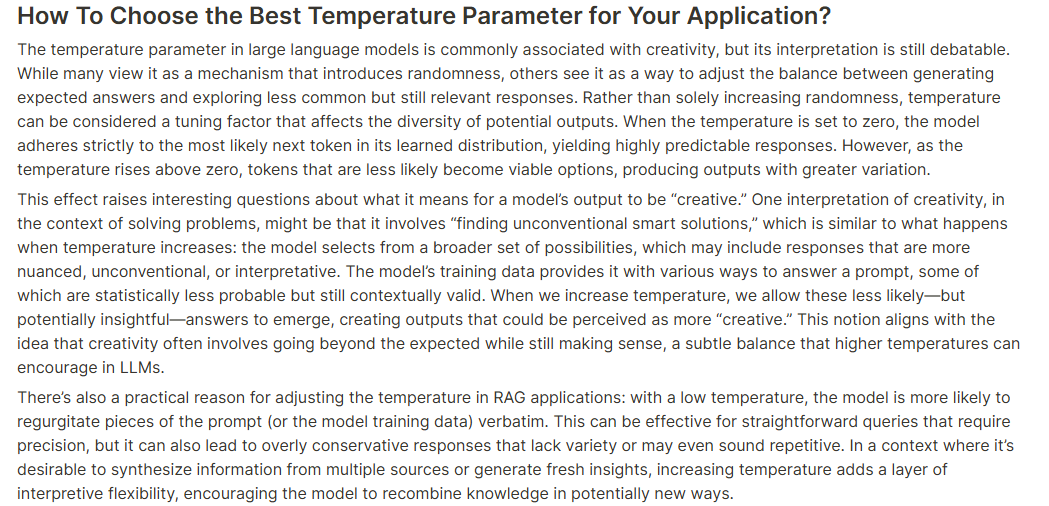

In [103]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_API_KEY"],
)


def rag_answer(chunks, question, temperature=0.1, model="google/gemini-2.5-flash"):
    system_instruction = (
        "You are a grounded RAG assistant. Use only the provided context. "
        "If the answer is not present in the context, say you don't know. "
        "Cite chunk indices you used."
    )

    context_text = "\n\n".join(f"[chunk {i}] {text}" for i, text in enumerate(chunks))
    user_prompt = (
        "Use only the content in <START_OF_CONTEXT> ... <END_OF_CONTEXT>.\n\n"
        f"<START_OF_CONTEXT>\n{context_text}\n<END_OF_CONTEXT>\n\n"
        f"Question: {question}\n"
        "Answer succinctly and cite [chunk i] references."
    )

    resp = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_instruction},
            {"role": "user", "content": user_prompt},
        ],
        temperature=temperature,  # <= increase this value to add randomness
        # You can also adjust top_p for nucleus sampling (often use one or the other)
        # top_p=1.0,
    )
    return resp.choices[0].message.content


# Usage:
chunks_play = [
    "LLaMA 2 is a family of LLMs released by Meta in 2023.",
    "The models come in sizes 7B, 13B, and 70B parameters.",
]
question_play = "What sizes does LLaMA 2 come in?"

# Deterministic (best for factual Q&A)
print(rag_answer(chunks_play, question_play, temperature=0.0))

# Slightly more varied style (still grounded)
print(rag_answer(chunks_play, question_play, temperature=0.5))

# Creative/verbose style (use carefully in RAG)
print(rag_answer(chunks_play, question_play, temperature=0.9))


LLaMA 2 comes in sizes 7B, 13B, and 70B parameters. [chunk 1]
LLaMA 2 comes in sizes 7B, 13B, and 70B parameters. [chunk 1]
LLaMA 2 comes in sizes 7B, 13B, and 70B parameters. [chunk 1]


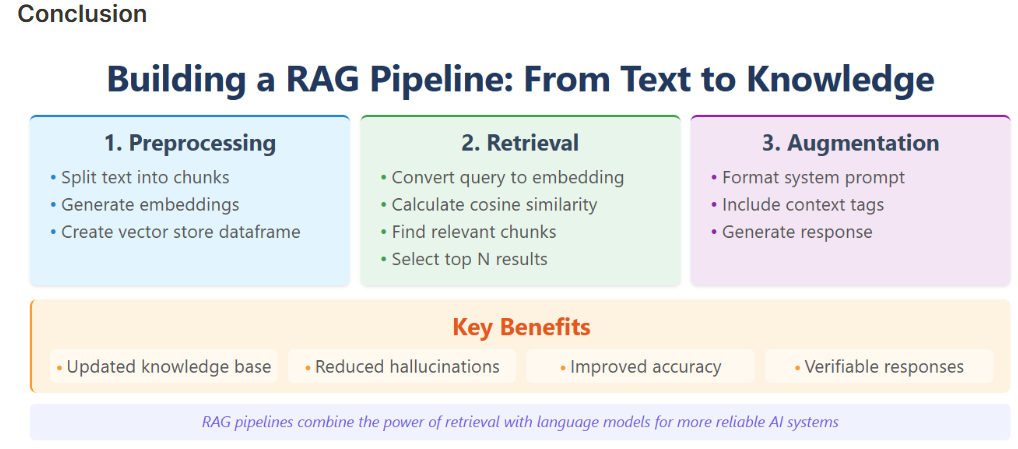